# COURSE PROJECT: NEURAL NETWORKS FOR CLASSIFICATION

**SINH VIÊN 1**

Họ tên: Nguyễn Hoàng Khải Minh

MSSV: 22127267

<br>

**SINH VIÊN 2**

Họ tên: 

MSSV: 22127

<br>
(Cập nhật lần cuối: 23/11/2024)

## Import các thư viện cần thiết

In [42]:
import numpy as np
import os
import pickle
import tarfile
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 1. Data preparation

In [185]:
def read_cifar(cifar_file):
    if os.path.isfile(cifar_file) == False:
        cifar_file = os.path.join(os.path.expanduser('~'), 'data', 'cifar-10-python.tar.gz')
    
    with tarfile.open(cifar_file, 'r:gz') as tar:
        # Extract the CIFAR-100 files
        tar.extractall()
    
    # Load the train data
    train_X = []
    train_Y = []


    for i in range (1, 6):
        with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
            train_data = pickle.load(f, encoding='bytes')
            train_X.append((train_data[b'data']) / 255.0)
            train_Y.append(train_data[b'labels'])
    train_X = np.concatenate(train_X, axis=0)
    train_Y = np.concatenate(train_Y)
    
    # Load the test data
    with open('cifar-10-batches-py/test_batch', 'rb') as f:
        test_data = pickle.load(f, encoding='bytes')
        test_X = np.array(test_data[b'data']) / 255.0
        test_Y = np.array(test_data[b'labels'])

    return train_X, train_Y, test_X, test_Y


train_X, train_Y, test_X, test_Y = read_cifar('cifar-10-python.tar.gz')

print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_Y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_Y.shape}')

Shape of train_X: (50000, 3072), shape of train_y: (50000,)
Shape of test_X:  (10000, 3072), shape of test_y:  (10000,)


In [186]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 1.0


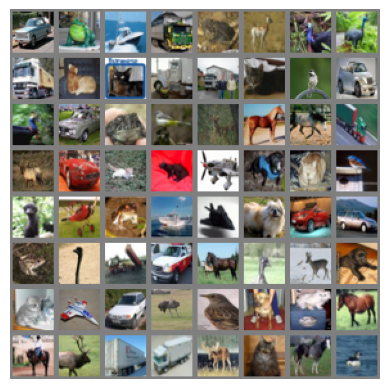

In [187]:
# Bạn có thể chạy cell này nhiều lần để xem các ảnh ngẫu nhiên khác nhau
n_rimages = 8; n_cimages = 8 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (32 + 2 * padding), n_cimages * (32 + 2 * padding), 3))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(3, 32, 32).transpose(1, 2, 0)
        temp1 = r * (32 + 2 * padding) + padding 
        temp2 = c * (32 + 2 * padding) + padding 
        canvas[temp1:temp1 + 32, temp2:temp2 + 32, :] = image
plt.imshow(canvas, vmin=0, vmax=1)
plt.axis('off');

In [188]:
def load_meta(meta_file):
    with open(meta_file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
    return meta_data[b'label_names']

# Ví dụ:
meta_file = 'cifar-10-batches-py/batches.meta'
label_names = load_meta(meta_file)

values, counts = np.unique(train_Y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value} - {label_names[value].decode('utf-8')}, count: {count}')

Value: 0 - airplane, count: 5000
Value: 1 - automobile, count: 5000
Value: 2 - bird, count: 5000
Value: 3 - cat, count: 5000
Value: 4 - deer, count: 5000
Value: 5 - dog, count: 5000
Value: 6 - frog, count: 5000
Value: 7 - horse, count: 5000
Value: 8 - ship, count: 5000
Value: 9 - truck, count: 5000


In [189]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

def one_hot(Y):
    K = np.max(Y) + 1
    y_onehot = np.zeros((len(Y), K))
    y_onehot[np.arange(len(Y)), Y] = 1
    return y_onehot

# Gọi hàm add_ones để tiền xử lý train_X
train_Z = add_ones(train_X)
print(f'Shape of train_Z: {train_Z.shape}')

# Gọi hàm one_hot để tiền xử lý train_Y
train_Y_onehot = one_hot(train_Y)
train_Y_onehot.shape
print(f'Shape of train_Y_onehot: {train_Y_onehot.shape}')


Shape of train_Z: (50000, 3073)
Shape of train_Y_onehot: (50000, 10)


## 2. Model Design

| Hyperparameter        | Value             |
|-----------------------|-------------------|
| Number of layers      | 2 hidden layers   |
| Neurons per layer     | 512               |
| Activation function   | ReLU              |
| Optimizer             | Adam              |
| Learning rate         | 0.001             |
| Weight decay          | 0.0001            |
| Epsilon               | 1e-7              |
| Epochs                | 100               |
| Batch size            | 200               |
| Loss function         | Cross-entropy     |
| Validation fraction   | 0.1               |
| Early stopping        | True              |

**SKLEARN**

In [ ]:
# Number of layers: 2 hidden layers
# Neuron per layer: 512
# Activation function: ReLU (default)
# Optimizer: Adam (default)
# Learning rate: 0.001 (default)
# Weight decay: 0.0001 (default)
# epsilon: 1e-7 
# Epochs: 100
# Batch size: 200 (default)
# Loss function: Cross-entropy

def mlp_sklearn(X, y):
    from sklearn.neural_network import MLPClassifier
    model = MLPClassifier(
        hidden_layer_sizes=(512, 512), 
        max_iter=100, 
        alpha=0.0001,
        epsilon=1e-7,
        solver='adam', 
        verbose=True, 
        learning_rate_init=0.001,
        validation_fraction=0.1,
        early_stopping=True
    )
    model.fit(X, y)
    return model


In [ ]:
# Huấn luyện mô hình
model_sklearn = mlp_sklearn(train_Z, train_Y)

**TENSORFLOW**

In [177]:
# Number of layers: 2 hidden layers
# Neuron per layer: 512
# Activation function: ReLU
# Optimizer: Adam
# Learning rate: 0.001 (default)
# Weight decay: 0.0001 
# epsilon: 1e-7 (default)
# Epochs: 100
# Batch size: 200
# Loss function: Cross-entropy

def mlp_tf(X, y):
    import tensorflow as tf
    from tensorflow.keras import layers, models
    model = models.Sequential([
        layers.Input(shape=(X.shape[1], )),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    adam = tf.keras.optimizers.Adam(weight_decay=0.0001)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X, 
        y, 
        epochs=100, 
        batch_size=200, 
        validation_split=0.1,
        callbacks=[tf.keras.callbacks.EarlyStopping()]
    )
    return model, history

In [ ]:
# Huấn luyện mô hình
model_tf, history_tf = mlp_tf(train_Z, train_Y_onehot)

**PYTORCH**

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)  # For multi-class classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.output(x)
        return self.softmax(x)

def mlp_pytorch(X_train, y_train, epochs=100, batch_size=200, learning_rate=0.001, weight_decay=0.0001, epsilon=1e-7):
    # **Prepare Data**
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    num_classes = len(torch.unique(torch.tensor(y_train)))
    input_size = X_train.shape[1]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # **Initialize Model**
    model = MLPModel(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=epsilon, weight_decay=weight_decay)

    # **Training Loop**
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return model

In [ ]:
# Huấn luyện mô hình
model_pytorch = mlp_pytorch(train_Z, train_Y)